# Home assignment 1

### Deadline: 4th December, 2024 at 23:59 CET

### Name:
### Student No.:

In this assignment we go through the following topics:
- Making a Data set class that inherits from `torch.utils.data.Dataset`
- Data Augmentation
- Transfer Learning or Fine Tuning
- Making a function for training

We are going to implement an image segmentation model for a pet dataset. We will use a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

### Image Segmentation

In an image segmentation task, a class is assigned to each pixel of the image.

Image segmentation is typically used to locate objects and boundaries in images and has many applications in medical imaging, self-driving cars and satellite imaging, for example.


This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

   * Class 1: Pixel belonging to the pet.
   * Class 2: Pixel bordering the pet.
   * Class 3: None of the above/a surrounding pixel.

### Setup


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional
from torchvision.transforms import functional as F
import random
%pip install torchmetrics
import torchmetrics
from torchmetrics.classification import Dice

# Define a directory where you want to store the dataset
# We recommend using Colab, if you do not have a GPU!
colab_dir = "./testing/ColabNotebooks/"  # Update this with your directory

# Load the dataset using the updated paths
pets_path_train = os.path.join(colab_dir, "OxfordPets", "train")
pets_path_test = os.path.join(colab_dir, "OxfordPets", "test")

### Define Datasets
The dataset consists of `(image, mask)` tuples. The image is a standard RGB PIL image. The masks are a single-channel PIL image where each pixel is one of the three category label values (0, 1 or 2).
PIL images can be transformed to Tensors using [torchvision.transforms.functional.pil_to_tensor](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.pil_to_tensor) or vice-versa with [torchvision.transforms.functional.to_pil_image](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.to_pil_image).

In [2]:
# Define the dataset and test dataset
dataset = torchvision.datasets.OxfordIIITPet(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=True,
)
dataset_test = torchvision.datasets.OxfordIIITPet(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=True,
)

100%|██████████| 792M/792M [00:36<00:00, 21.8MB/s]


Extracting testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet/images.tar.gz to testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 9.20MB/s]


Extracting testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet


100%|██████████| 792M/792M [00:33<00:00, 23.3MB/s]


Extracting testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet/images.tar.gz to testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 8.66MB/s]


Extracting testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet


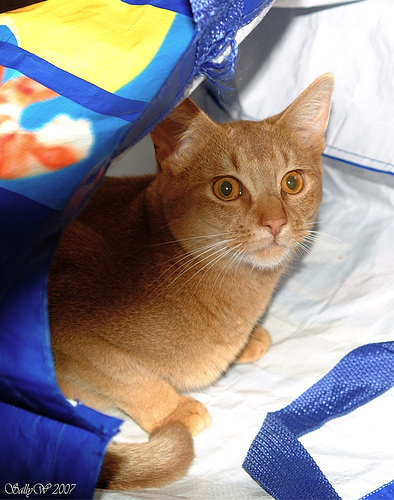

In [3]:
image, mask = dataset[0]
# Show one image
image

In [4]:
# Print the mask Tensor
functional.pil_to_tensor(mask)

tensor([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]], dtype=torch.uint8)

### Define transforms

These transforms augment the training data to improve the robustness of the model.
Use at least 3 different transforms for augmenting the data.
The transforms should augment the image, e.g., distort, crop or rotate.
Transforms that only convert the image to Tensors do not count as augmentation.

See https://pytorch.org/vision/0.11/transforms.html for a list of all transforms.


In [5]:
# Image and mask transformations
image_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]
)

mask_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]
)

### Define Collate Functions and Dataloaders
Notes:
- You do not have to use collate functions. However they are an easy way to apply methods to and order the data. The data is given as a list of `(image, mask)` tuples, but depending on your implementation, it may be beneficial to load the batches as a tuple of lists, i.e., `([images], [masks])`. The required reordering can be achieved using a collate function.
- Apply the above transforms to the training data. Keep in mind, you should apply the same transforms to the image and mask.
- The model requires a binary mask. Set all pixels that are not the pet in the image to 0.
- You should use a separate collate function for the train and test set. The test set does not need to be transformed, but converted to tensors.

In [6]:
# Custom collate function for synchronization
def collate_train(batch):
    images, masks = zip(*batch)

    transformed_images = []
    transformed_masks = []

    for image, mask in zip(images, masks):
        # Apply the same random seed to synchronize transformations
        seed = random.randint(0, 10000)
        random.seed(seed)
        image = image_transforms(image)

        random.seed(seed)
        mask = mask_transforms(mask)

        transformed_images.append(image)
        transformed_masks.append(mask)

    return transformed_images, transformed_masks


# Collate function for testing (no augmentation)
def collate_test(batch):
    images, masks = zip(*batch)
    images = [transforms.ToTensor()(image) for image in images]
    masks = [transforms.ToTensor()(mask) for mask in masks]
    return images, masks

In [7]:
# Create data loaders for training and testing
batch_size = 4
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_train,
)
data_loader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_test,
)

### Example images
To check that the masks and transforms are calculated correctly, plot four images, their masks, the transformed version and the corresponding mask.

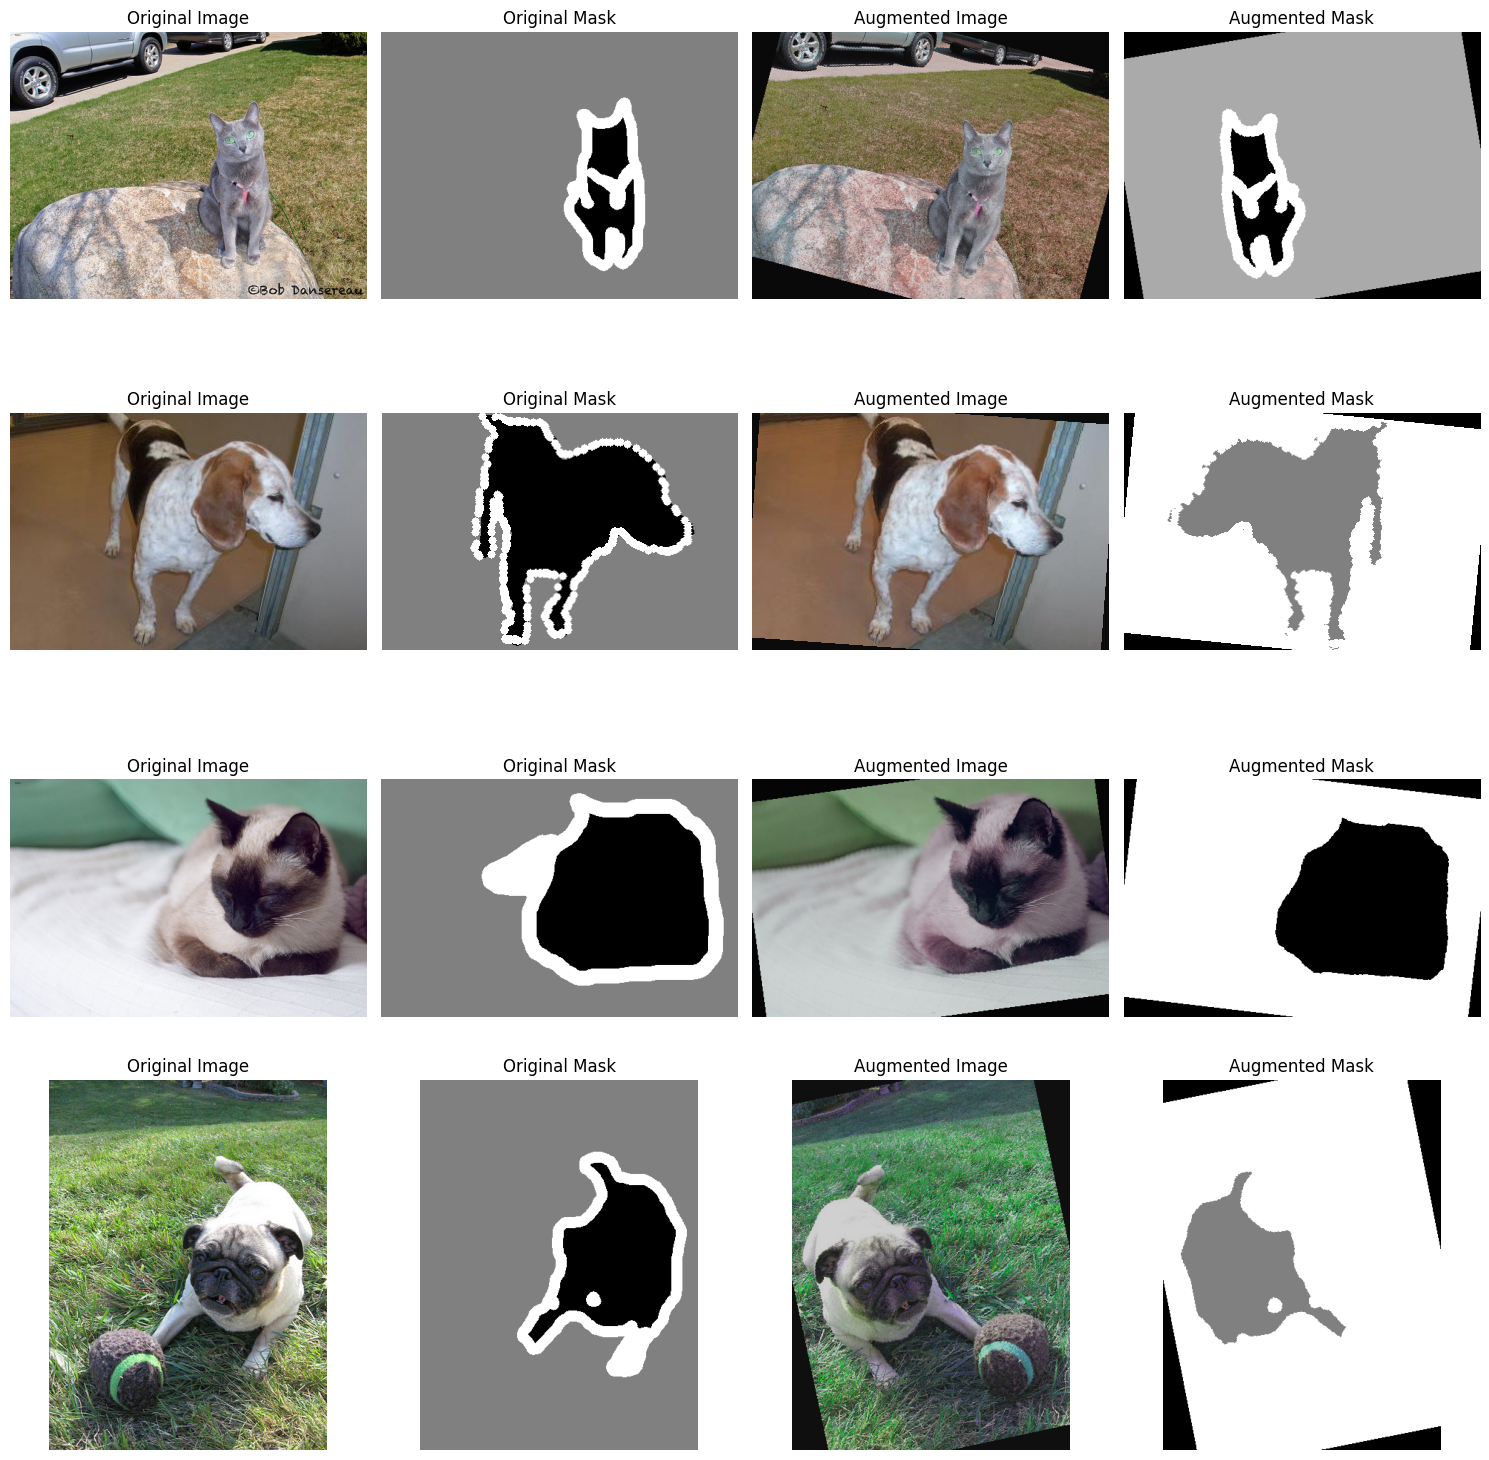

In [10]:
# Visualization
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Number of samples to visualize
num_samples = 4

# Randomly select unique indices from the dataset
random_indices = random.sample(range(len(dataset)), num_samples)

for i, idx in enumerate(random_indices):
    # Fetch original image and mask
    original_image, original_mask = dataset[idx]  # Use random indices
    original_image_tensor = transforms.ToTensor()(original_image)
    original_mask_tensor = transforms.ToTensor()(original_mask)
    original_image_pil = F.to_pil_image(original_image_tensor)
    original_mask_pil = F.to_pil_image(original_mask_tensor)

    # Synchronize random transformations
    seed = random.randint(0, 10000)
    random.seed(seed)
    augmented_image = image_transforms(original_image_pil)

    random.seed(seed)
    augmented_mask = mask_transforms(original_mask_pil)

    # Convert augmented_image to a PyTorch tensor
    augmented_image_tensor = transforms.ToTensor()(augmented_image)

    # Convert augmented_mask to a PyTorch tensor
    augmented_mask_tensor = transforms.ToTensor()(augmented_mask) # Convert to tensor

    # Plot original image and mask
    axes[i, 0].imshow(original_image_pil)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(original_mask_pil, cmap="gray")
    axes[i, 1].set_title("Original Mask")
    axes[i, 1].axis("off")

    # Plot augmented image and mask
    axes[i, 2].imshow(augmented_image_tensor.permute(1, 2, 0)) # Use the tensor here
    axes[i, 2].set_title("Augmented Image")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(augmented_mask_tensor.squeeze(), cmap="gray") # Call squeeze on the tensor
    axes[i, 3].set_title("Augmented Mask")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

### Introduction to transfer learning


* Transfer learning is an ML methods to **reuse a pre-trained model** on a new problem by exploiting the knowledge gained from a previous task to improve generalization about another similar task.
* Steps:
  1. Select a pre-trained source model
  2. Adapt the source model to create the target model
  3. Fine-tuning: Train source model to achieve the target model
* Strategies for fine-tuning of model:
* There are different **strategies for fine-tuning** the model: You can train the entire model or only some layers and leave the others frozen. Usually, if you have a small dataset and a large number of parameters, you will leave more layers frozen to avoid overfitting. By contrast, if the dataset is large and the number of parameters is small, you can improve your model by training more layers to the new task since overfitting is not an issue.
* **Main benefits:** less training data needed, better initial model, higher learning rate, faster training, higher accuracy after training
* **Example:** In training a classifier to predict the animal species, you could use the knowledge it gained during training to recognize dog breeds.


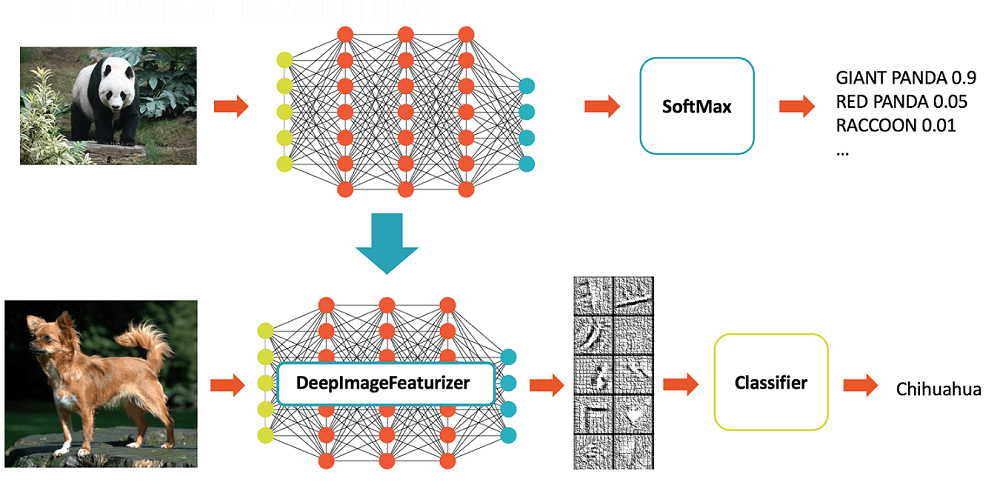

### Defining model and Prediction

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

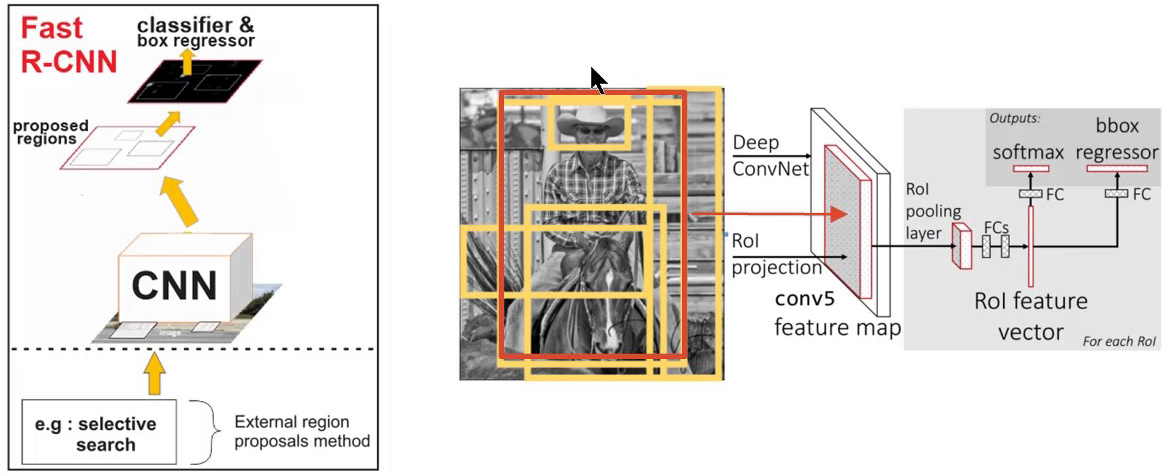


Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

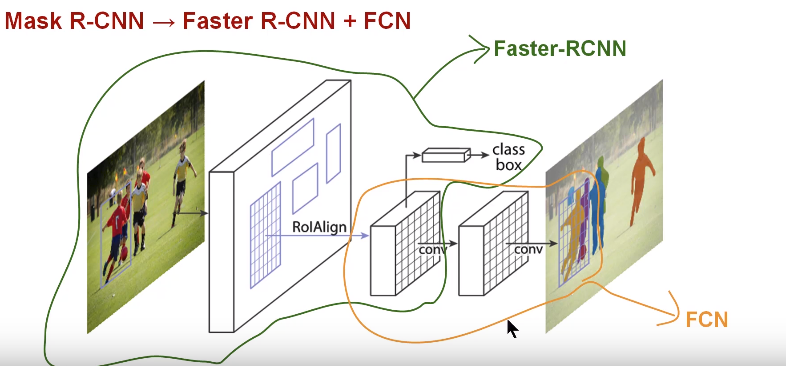





One of popular ways to modify models in torchvision modelzoo when we want to use a pre-trained model, and just finetune the last layer is transfer learning. In our task we want to also compute the segmentation masks, so we will be using Mask R-CNN.

### Define some hyperparameters:
Feel free to test some other options

In [11]:
NUM_CLASSES = 3
HIDDEN_LAYER = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

This part initializes the model, optimizer and learning rate scheduler.

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model Setup:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

# Get the number of input features for the classifier and replace the head for the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head for the box predictor with FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Get the number of input features for the mask classifier and replace the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# Replace the mask predictor with MaskRCNNPredictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, HIDDEN_LAYER, NUM_CLASSES
)

# Move the model to the appropriate device
model.to(device)


# Optimizer and Learning Rate Scheduler:
# Create an optimizer with proper lr, momentum, and weight decay
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001
)

# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 70.8MB/s]


Some notes that may or may not be applicable to you:
- You may have to check if a bounding box is valid (i.e., contains foreground and is not 0-width or 0-height)
- Filter out all masks that have invalid bounding boxes

Now, let’s make a function for training each epoch:

In [13]:
# Define data transformations
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


# Function to get bounding boxes from masks
def get_boxes(mask):
    pos = mask.squeeze().nonzero()  # Get non-zero positions
    boxes = torch.as_tensor(
        [
            torch.min(pos[:, 1]),  # x_min
            torch.min(pos[:, 0]),  # y_min
            torch.max(pos[:, 1]),  # x_max
            torch.max(pos[:, 0]),  # y_max
        ],
        dtype=torch.int64,
    ).unsqueeze(
        0
    )  # Add batch dimension
    return boxes


# Training function
def train(model, optimizer, dataloader, device, epoch, print_freq=1):
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss
    batch_count = 0  # Initialize batch count

    for images, masks in dataloader:
        batch_count += 1

        # Clear cache before processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Convert the PIL Images to PyTorch tensors and move to device
        images = [data_transforms(image).to(device) for image in images]
        masks = [data_transforms(mask).to(device) for mask in masks]

        # Create targets for the model
        targets = [
            {
                "boxes": get_boxes(masks[i]).to(device),  # Bounding boxes
                "labels": torch.ones(1, dtype=torch.int64).to(
                    device
                ),  # Labels (all ones)
                "masks": masks[i],  # Masks
                "image_id": i,  # Image ID
            }
            for i in range(len(images))
        ]

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)  # More memory efficient than False

        try:
            # Forward pass with gradient checkpointing
            with torch.cuda.amp.autocast():  # Mixed precision training
                loss_dict = model(images, targets)  # Get loss dictionary

            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            # Backward pass and optimize
            losses.backward()
            optimizer.step()

            # Explicitly clear some variables to free memory
            del images, masks, targets, loss_dict, losses
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "out of memory" in str(e):
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                print(f"OOM at batch {batch_count}. Skipping batch...")
                continue
            else:
                raise e

        # Print progress
        if batch_count % print_freq == 0:
            avg_loss = total_loss / batch_count
            print(
                f"Epoch: [{epoch}] Batch: [{batch_count}] Average Loss: {avg_loss:.4f}"
            )

    # Return average loss for the epoch
    return total_loss / batch_count

In [15]:
# GPU memory optimization
# Update training configuration
batch_size = 4
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_train,
)

# Enable gradient checkpointing on the model
model.backbone.body.requires_grad_(True)
model.backbone.body.train()

# Set PyTorch to be memory efficient
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    # Set memory allocator settings
    torch.cuda.set_per_process_memory_fraction(0.9)  # Use only 90% of available memory

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

<ipython-input-13-0e6c164817f7>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision training


Epoch: [0] Batch: [10] Average Loss: 0.2160
Epoch: [0] Batch: [20] Average Loss: 0.2067
Epoch: [0] Batch: [30] Average Loss: 0.2058
Epoch: [0] Batch: [40] Average Loss: 0.1983
Epoch: [0] Batch: [50] Average Loss: 0.1956
Epoch: [0] Batch: [60] Average Loss: 0.1931
Epoch: [0] Batch: [70] Average Loss: 0.1898
Epoch: [0] Batch: [80] Average Loss: 0.1865
Epoch: [0] Batch: [90] Average Loss: 0.1862
Epoch: [0] Batch: [100] Average Loss: 0.1851
Epoch: [0] Batch: [110] Average Loss: 0.1847
Epoch: [0] Batch: [120] Average Loss: 0.1831
Epoch: [0] Batch: [130] Average Loss: 0.1813
Epoch: [0] Batch: [140] Average Loss: 0.1806
Epoch: [0] Batch: [150] Average Loss: 0.1784
Epoch: [0] Batch: [160] Average Loss: 0.1771
Epoch: [0] Batch: [170] Average Loss: 0.1752
Epoch: [0] Batch: [180] Average Loss: 0.1729
Epoch: [0] Batch: [190] Average Loss: 0.1700
Epoch: [0] Batch: [200] Average Loss: 0.1682
Epoch: [0] Batch: [210] Average Loss: 0.1661
Epoch: [0] Batch: [220] Average Loss: 0.1641
Epoch: [0] Batch: [

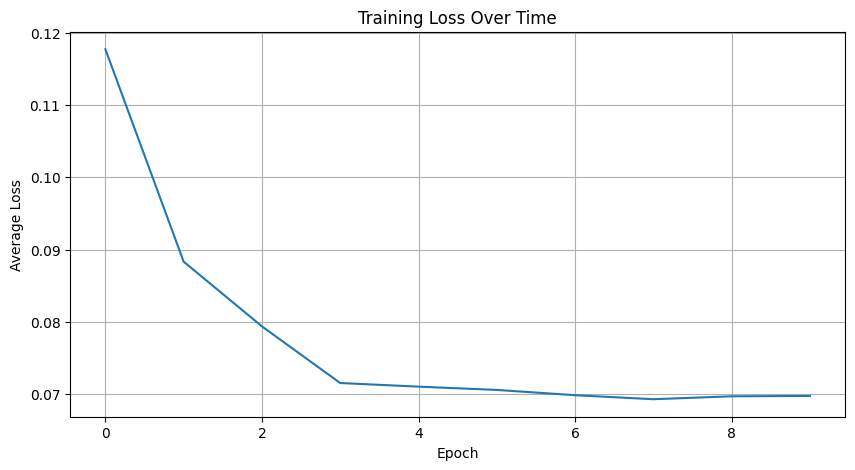

In [16]:
# Update the training loop to track and display the losses
num_epochs = 10
epoch_losses = []

for epoch in range(num_epochs):
    avg_loss = train(model, optimizer, data_loader, device, epoch, print_freq=10)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch} completed. Average loss: {avg_loss:.4f}")
    lr_scheduler.step()

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), epoch_losses)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.
### Training and evaluation:


### Prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image

In [17]:
# Pick one image from the test set
img, _ = dataset_test[0]

# Put the model in evaluation mode
model.eval()

# Transform the image and move it to the appropriate device
img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

# Make predictions
with torch.no_grad():
    prediction = model(img_tensor)

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed.

In [18]:
prediction

[{'boxes': tensor([[3.2808e-03, 0.0000e+00, 2.9902e+02, 2.2500e+02]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9999], device='cuda:0'),
  'masks': tensor([[[[1.6786e-12, 2.0035e-12, 2.3284e-12,  ..., 3.4073e-12,
             2.9319e-12, 2.4564e-12],
            [2.0544e-12, 2.4521e-12, 2.8497e-12,  ..., 4.1702e-12,
             3.5883e-12, 3.0064e-12],
            [2.4302e-12, 2.9006e-12, 3.3710e-12,  ..., 4.9330e-12,
             4.2447e-12, 3.5563e-12],
            ...,
            [4.9439e-07, 5.9008e-07, 6.8577e-07,  ..., 5.8138e-15,
             5.0025e-15, 4.1913e-15],
            [4.2818e-07, 5.1105e-07, 5.9393e-07,  ..., 5.0351e-15,
             4.3326e-15, 3.6300e-15],
            [3.6197e-07, 4.3203e-07, 5.0208e-07,  ..., 4.2565e-15,
             3.6626e-15, 3.0686e-15]]]], device='cuda:0')}]

Let's inspect and visualize the image and the top predicted segmentation masks.


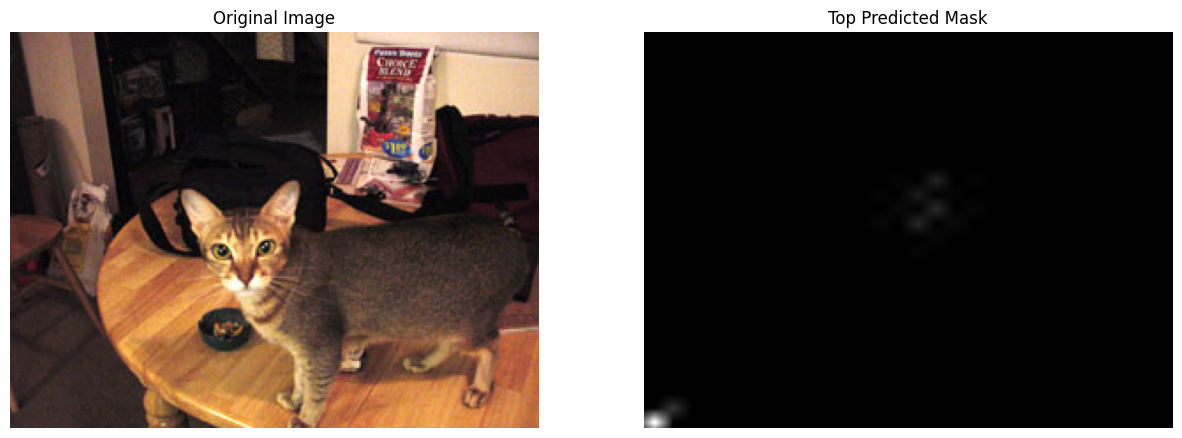

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Original image
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Process the mask
top_mask = prediction[0]["masks"][0, 0]
top_mask = (top_mask - top_mask.min()) / (top_mask.max() - top_mask.min())  # Normalize
top_mask = (top_mask * 255).byte().cpu().numpy()  # Scale to 0-255

# Top predicted mask
ax[1].imshow(top_mask, cmap="gray")
ax[1].set_title("Top Predicted Mask")
ax[1].axis("off")

plt.show()

And let's now visualize the top predicted segmentation mask.

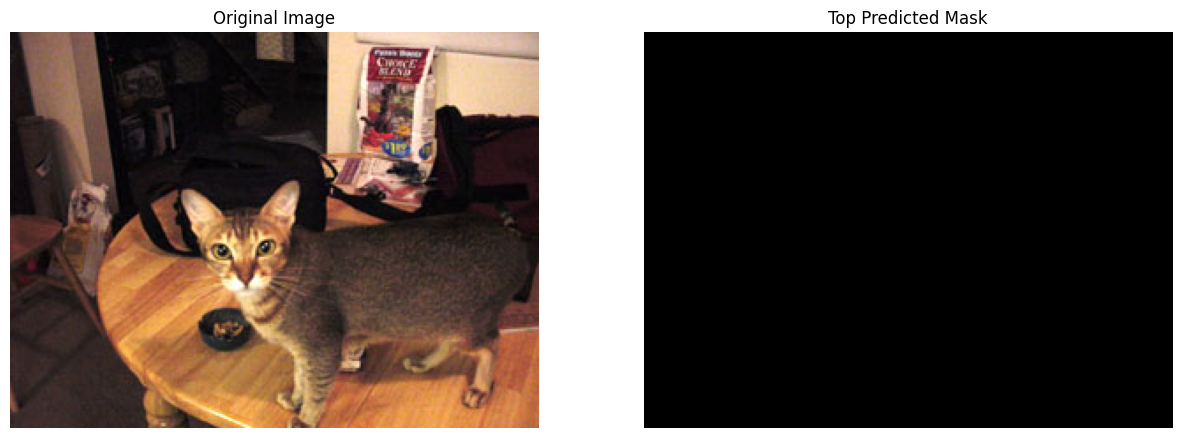

In [21]:
# TODO
# Visualize the top predicted segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# Original image
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Top predicted mask
top_mask = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
ax[1].imshow(top_mask, cmap="gray")
ax[1].set_title("Top Predicted Mask")
ax[1].axis("off")

plt.show()

For some other examples visualize original image and all predicted segmentation masks.

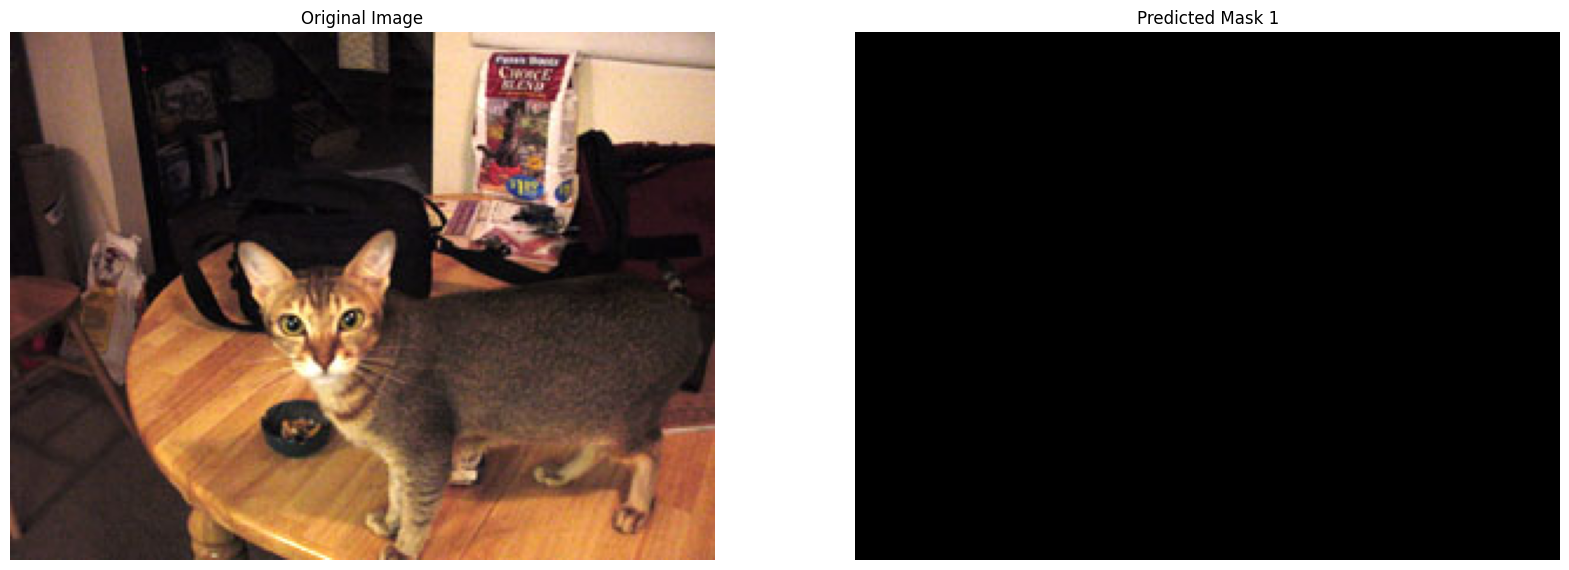

In [22]:
# TODO
# Visualize original image and all predicted segmentation masks
fig, axes = plt.subplots(1, len(prediction[0]["masks"]) + 1, figsize=(20, 20))

# Original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted masks
for i in range(len(prediction[0]["masks"])):
    mask = prediction[0]["masks"][i, 0].mul(255).byte().cpu().numpy()
    axes[i + 1].imshow(mask, cmap="gray")
    axes[i + 1].set_title(f"Predicted Mask {i + 1}")
    axes[i + 1].axis("off")

plt.show()

### Evaluation
In semantic segmentation tasks, you want to assess the quality of pixel-wise predictions made by your model. This includes metrics like Intersection over Union (IoU), Dice Coefficient, and Pixel Accuracy.

We recommend using [torchmetrics](https://torchmetrics.readthedocs.io/en/v0.9.3/).

In [30]:
# TODO: Evaluate your model and compute relevant semantic segmentation metrics
# 1. Calculate and print the Intersection over Union (IoU) for each class and the mean IoU.
# 2. Calculate and print the Dice Coefficient for each class and the mean Dice Coefficient.
# 3. Compute and print the Pixel Accuracy.

# Initialize metric objects
iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=NUM_CLASSES, average='none').to(device)

dice_metric = Dice(num_classes=2, average='micro').to(device)  # or average=None if you want per-class scores
accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)

# Put the model in evaluation mode
model.eval()

# Initialize lists to store metric values
iou_values = []
dice_values = []
accuracy_values = []

# Iterate over the test dataset
for images, masks in data_loader_test:
    images = [img.to(device) for img in images]
    masks = [mask.to(device) for mask in masks]

    with torch.no_grad():
        predictions = model(images)

for i in range(len(images)):
    pred_mask = predictions[i]['masks'][0, 0].sigmoid().round()
    true_mask = masks[i]

    # **Convert true_mask to integer tensor**
    true_mask = true_mask.long()

    # **Squeeze the true_mask to remove the extra dimension**
    true_mask = true_mask.squeeze(0)

    # Update metrics
    iou_values.append(iou_metric(pred_mask, true_mask).cpu().numpy())
    dice_values.append(dice_metric(pred_mask.long(), true_mask).cpu().numpy())
    accuracy_values.append(accuracy_metric(pred_mask, true_mask).cpu().numpy())

# Calculate mean values for each metric
mean_iou = np.mean(iou_values, axis=0)
mean_dice = np.mean(dice_values, axis=0)
mean_accuracy = np.mean(accuracy_values)

# Print the metrics
print(f"Intersection over Union (IoU) for each class: {mean_iou}")
print(f"Mean IoU: {np.mean(mean_iou)}")
print(f"Dice Coefficient for each class: {mean_dice}")
print(f"Mean Dice Coefficient: {np.mean(mean_dice)}")
print(f"Pixel Accuracy: {mean_accuracy}")

Intersection over Union (IoU) for each class: [0.98904 0.      0.     ]
Mean IoU: 0.3296799957752228
Dice Coefficient for each class: 0.9890400171279907
Mean Dice Coefficient: 0.9890400171279907
Pixel Accuracy: 0.9890400171279907
